In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/RL/C51/C51
 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/RL/C51/C51


In [2]:
!pip install -r ../requirements.txt

In [3]:
!pip install -e .

Obtaining file:///content/drive/MyDrive/RL/C51/C51
  Running setup.py develop for gym-cartpolemod


# C51

CartPoleModEnv - Version 0.2.0, Noise case: 2
We are in episode 1
The reward is 9.0
We are in episode 2
The reward is 10.0
We are in episode 3
The reward is 8.0
We are in episode 4
The reward is 8.0
We are in episode 5
The reward is 10.0


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Environment '<class 'gym_cartpolemod.envs.cartpolemod_env.CartPoleModEnv'>' has deprecated methods '_step' and '_reset' rather than 'step' and 'reset'. Compatibility code invoked. Set _gym_disable_underscore_compat = True to disable this behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


We are in episode 6
The reward is 9.0
We are in episode 7
The reward is 13.0
We are in episode 8
The reward is 22.0
We are in episode 9
The reward is 18.0
We are in episode 10
The reward is 16.0
We are in episode 11
The reward is 26.0
We are in episode 12
The reward is 9.0
We are in episode 13
The reward is 9.0
We are in episode 14
The reward is 10.0
We are in episode 15
The reward is 9.0
We are in episode 16
The reward is 72.0
We are in episode 17
The reward is 37.0
We are in episode 18
The reward is 25.0
We are in episode 19
The reward is 21.0
We are in episode 20
The reward is 31.0
We are in episode 21
The reward is 18.0
We are in episode 22
The reward is 25.0
We are in episode 23
The reward is 28.0
We are in episode 24
The reward is 40.0
We are in episode 25
The reward is 36.0
We are in episode 26
The reward is 43.0
We are in episode 27
The reward is 116.0
We are in episode 28
The reward is 122.0
We are in episode 29
The reward is 143.0
We are in episode 30
The reward is 104.0
We a

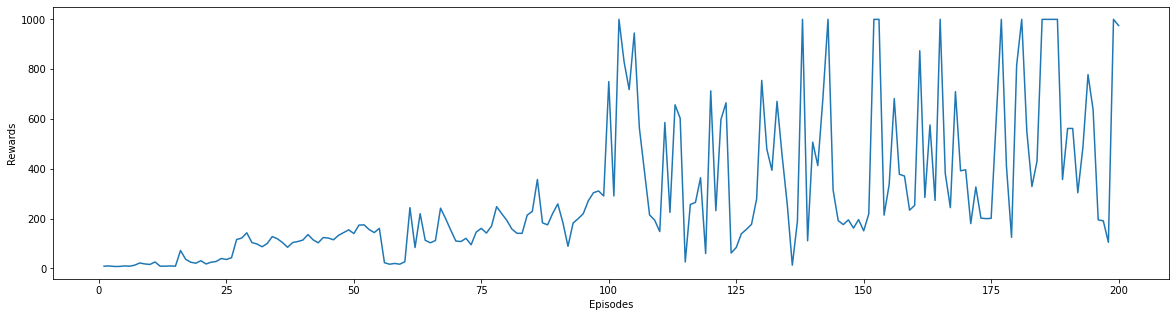

In [4]:
import copy
import random
import numpy as np 
import gym
import torch
import gym_cartpolemod
import memory
from memory import Transition
import networks
import matplotlib.pyplot as plt

def extract(transitions):
    """Extract tensors of s, a, r, s' from a batch of transitions.

    Args:
        transitions (list): List of Transition named tuples where next_state is None if episode
            ended.

    Returns:
        (states, actions, rewards, next_states, mask) that are all (batch_size, *shape) tensors
        containing the extracted data. next_states does not contain elements for episode that
        ended. mask is a boolean tensor that specifies which transitions have a next state.
    """
    states = torch.cat([t.state for t in transitions])
    actions = torch.cat([t.action for t in transitions])
    rewards = torch.cat([t.reward for t in transitions])
    mask = torch.tensor([t.next_state is not None for t in transitions])
    next_states = torch.cat([t.next_state for t in transitions if t.next_state is not None])
    return states, actions, rewards, next_states, mask



def check_state(state):

    for i in range(len(state[0])):
        if isinstance(state[0][i], np.ndarray):
            state[0][i] = state[0][i][0]

    state = np.vstack(state[:, :]).astype(np.float)
    state = state[0]

    return state




def select_argmax_action(z, atoms):
    # Take state-action distribution z, which is a (batch_size, action_size, n_atoms) and
    # returns a tensor of shape (batch_size, 1) with the greedy actions for each state
    q_values = (z * atoms[:, None, :]).sum(dim=-1)
    return q_values.argmax(dim=-1).unsqueeze(1)


class CategoricalDQN:

    def __init__(self, z_net, n_atoms, v_min, v_max, df=0.99, buffer_len=1e6, batch_size=32,
                 lr=0.5e-3, update_mode='hard', update_every=5, tau=0.05, epsilon=0.1,
                 start_train_at=4000, state_size = None, results_dir=None):
        self.z_net = z_net
        self.n_atoms = n_atoms
        self.v_min = v_min
        self.v_max = v_max
        self.delta = (v_max - v_min) / n_atoms
        self.df = df
        self.buffer_len = buffer_len
        self.batch_size = batch_size
        self.update_mode = update_mode
        self.update_target_every = update_every
        self.tau = tau
        self.state_size = state_size
        self.epsilon = epsilon
        self.start_train_at = start_train_at
        self.replay_buffer = memory.TransitionReplayBuffer(maxlen=buffer_len)
        self._target_net = copy.deepcopy(z_net)
        self.optimizer = torch.optim.Adam(self.z_net.parameters(), lr=lr)
        self.atoms = torch.arange(self.v_min, self.v_max, self.delta).unsqueeze(0)

    def train(self, env: gym.Env, n_episodes):
        rewards = []
        episode_list = []
        episode_rewards = 0
        state = env.reset()
        episode = 0
        step = 0
        state = np.reshape(state, [1, self.state_size])
        state = check_state(state)
        
        state = torch.from_numpy(state).float().unsqueeze(0) 
        
        while True:
            step = step + 1
            with torch.no_grad():
                z = self.z_net(state)
            if random.random() < self.epsilon:  # Random action
                action = torch.LongTensor([[env.action_space.sample()]])
            else:
                action = select_argmax_action(z, self.atoms)
            next_state, reward, done, info = env.step(action.squeeze().numpy())
            next_state = np.reshape(next_state, [1, self.state_size])
            next_state = check_state(next_state) 
            next_state = torch.from_numpy(next_state).float().unsqueeze(0) if not done else None
            
            self.replay_buffer.remember(
                Transition(state, action, torch.tensor([[reward]]), next_state))
            state = next_state


            self.train_single_step(step) 
            
            episode_rewards = episode_rewards + reward
            if done:
                state = env.reset()
                state = np.reshape(state, [1, self.state_size])
                state = check_state(state)
                state = torch.from_numpy(state).float().unsqueeze(0) 
                episode = episode + 1
                print("We are in episode", episode)
                print("The reward is", episode_rewards)
                rewards.append(episode_rewards)
                episode_list.append(episode)
                episode_rewards = 0

            if episode >= n_episodes: 
                break

        self.plot(episode_list, rewards)    



    def plot(self, episodes, rewards): 
        plt.figure(figsize=(20,5))
        plt.plot(episodes, rewards)
        plt.xlabel('Episodes')
        plt.ylabel('Rewards')
        plt.savefig('C51.png')
        print('plotted')



    def train_single_step(self, step):
        
        if step > self.start_train_at and self.replay_buffer.size() > self.batch_size:
            batch = self.replay_buffer.sample(self.batch_size)
            states, actions, rewards, next_states, mask = extract(batch)
            targets = self.compute_targets(rewards, next_states, mask)
            self.train_networks(states, actions, targets, update=(step % self.update_target_every) == 0)



    def train_networks(self, states, actions, targets, update):
        """Train both the evaluation and target nets  
            Evalution net is trained using a cross-entropy loss
            Target net is trained using a hard update (copy weights from evaluation net)
            Implement this function
        """
        self.optimizer.zero_grad()

        # Calc. loss
        z = self.z_net(states)
        z = z.gather(1, actions.repeat((1, self.n_atoms)).unsqueeze(1)).squeeze()
        loss = -(targets * z.log()).sum(dim=-1).mean()

        # Back propagation
        loss.backward()
        self.optimizer.step()

        # Update target network
        if update:
            self._target_net.load_state_dict(self.z_net.state_dict())


    
    def compute_targets(self, rewards, next_states, mask):
        """Compute the target distributions for the given transitions.
           The function returns the target distribution after distribution of the new probabilities 
            Implement this function
            For now returns a placeholder distribution. 
        """

        # - rewards:  torch.Size([32, 1])
        # - next_states: torch.Size([X, 4])
        # - mask: torch.Size([32])

        # Return of next state
        z_prime = self._target_net(next_states.detach())

        # Return values
        atoms = torch.arange(self.v_min, self.v_max, self.delta)
        atoms = (rewards + self.df * mask.unsqueeze(1) * atoms).clamp(min=self.v_min, max=self.v_max)
         
        # Calculate indices
        i = (atoms - self.v_min) / self.delta
        l = torch.floor(i).clamp(min=0).long()
        u = torch.ceil(i).clamp(max=self.n_atoms - 1).long()

        # Select greedy actions
        greedy_actions = select_argmax_action(z_prime, atoms[mask])
        
        # Calc. corresponding prob.
        z_prime = z_prime.gather(1, greedy_actions.repeat((1, self.n_atoms)).unsqueeze(1)).squeeze()
        probabilities = torch.ones((self.batch_size, self.n_atoms)) / self.n_atoms
        probabilities[mask] = z_prime

        # Compute partitions of atoms
        z_dist = torch.zeros(probabilities.shape)
        z_dist.scatter_add_(1, l, probabilities * (u - i))
        z_dist.scatter_add_(1, u, probabilities * (i - l))

        return z_dist



if __name__ == '__main__':
    
    env = gym.make('CartPoleMod-v1')
    state_dim = env.observation_space.shape[0]
    act_dim = env.action_space.n
    n_atoms = 51
    n_units = 64 
    n_layers = 2 
    z_net = networks.DistributionalNetwork(inputs=state_dim, n_actions=act_dim, n_atoms=n_atoms,
                                           n_hidden_units=n_units, n_hidden_layers=n_layers)
    v_min, v_max = [0, 200] 
    start_train_at = 32
    update_target_net_every = 5 
    epsilon = 0.1
    n_episodes = 200
    C51 = CategoricalDQN(z_net=z_net, n_atoms=n_atoms, v_min=v_min, v_max=v_max,
                          start_train_at=start_train_at,
                          update_every=update_target_net_every, epsilon=epsilon, state_size = state_dim)
    C51.train(env=env, n_episodes=n_episodes)



In [5]:
%cd ../DQN

/content/drive/My Drive/RL/C51/DQN


# DQN

CartPoleModEnv - Version 0.2.0, Noise case: 2


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Just completed episode 0
The reward is 17.0
Just completed episode 1
The reward is 14.0
Just completed episode 2
The reward is 10.0
Just completed episode 3
The reward is 9.0
Just completed episode 4
The reward is 10.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Just completed episode 5
The reward is 11.0
Just completed episode 6
The reward is 9.0
Just completed episode 7
The reward is 10.0
Just completed episode 8
The reward is 11.0
Just completed episode 9
The reward is 8.0
Just completed episode 10
The reward is 10.0
Just completed episode 11
The reward is 11.0
Just completed episode 12
The reward is 9.0
Just completed episode 13
The reward is 10.0
Just completed episode 14
The reward is 9.0
Just completed episode 15
The reward is 10.0
Just completed episode 16
The reward is 9.0
Just completed episode 17
The reward is 10.0
Just completed episode 18
The reward is 9.0
Just completed episode 19
The reward is 9.0
Just completed episode 20
The reward is 10.0
Just completed episode 21
The reward is 10.0
Just completed episode 22
The reward is 9.0
Just completed episode 23
The reward is 9.0
Just completed episode 24
The reward is 9.0
Just completed episode 25
The reward is 10.0
Just completed episode 26
The reward is 12.0
Just completed episode 27

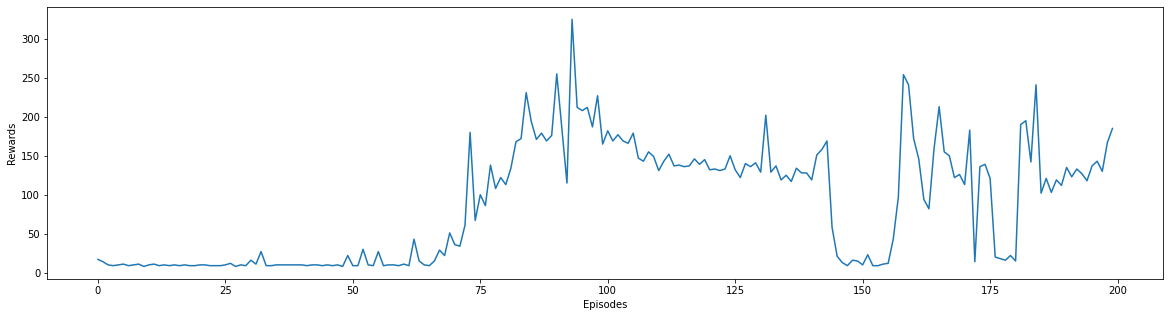

In [6]:
import math, random
import gym
import gym_cartpolemod
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F
import matplotlib.pyplot as plt


USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)


def check_state(state):

    for i in range(len(state[0])): 
        if isinstance(state[0][i], np.ndarray):
            state[0][i] = state[0][i][0]

    state = state[0]
    state = list(state)
    return state


    

from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)
env = gym.make('CartPoleMod-v1')

epsilon = 0.01


class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, env.action_space.n)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            with torch.no_grad():
                state = Variable(torch.FloatTensor(state).unsqueeze(0))
            q_value = self.forward(state)
            action  = q_value.max(1)[1].data[0]
        else:
            action = random.randrange(env.action_space.n)
        return action

model = DQN(env.observation_space.shape[0], env.action_space.n)
target_model = DQN(env.observation_space.shape[0], env.action_space.n)

def update_target(model, target_model):
    target_model.load_state_dict(model.state_dict())

update_target(model, target_model)

if USE_CUDA:
    model = model.cuda()
    target_model = target_model.cuda()
    
optimizer = optim.Adam(model.parameters())

replay_buffer = ReplayBuffer(1000)


def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)), volatile=True)
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))

    q_values      = model(state)
    next_q_values = target_model(next_state)

    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss


def plot(rewards):
    
    plt.figure(figsize=(20,5))
    plt.plot(rewards)
    plt.xlabel('Episodes')
    plt.ylabel('Rewards')
    plt.savefig('DQN.png')
    print('plotted')



batch_size = 32
gamma      = 0.9
total_episodes = 200
state_size = env.observation_space.shape[0]
episode = 0 
frame_idx = 0
losses = []
all_rewards = []
episode_reward = 0
episode = 0
state = env.reset()
state = np.reshape(state, [1, state_size])
state = check_state(state)
while True:
    action = model.act(state, epsilon)
    if(torch.is_tensor(action)): 
        action = action.tolist()
    next_state, reward, done, _ = env.step(action)
    next_state = np.reshape(next_state, [1, state_size])
    next_state = check_state(next_state)
    replay_buffer.push(state, action, reward, next_state, done) 
    state = next_state
    episode_reward += reward

    frame_idx = frame_idx + 1
    if done:
        print("Just completed episode", episode)
        state = env.reset()
        state = np.reshape(state, [1, state_size])
        state = check_state(state)
        episode = episode + 1
        all_rewards.append(episode_reward)
        print("The reward is", episode_reward)
        episode_reward = 0
    if episode >= total_episodes: 
        break

    if frame_idx % 100 == 0:
        update_target(model, target_model)

    if len(replay_buffer) > batch_size:
        loss = compute_td_loss(batch_size)
        new_loss = loss.data.tolist()
        losses.append(new_loss)

plot(all_rewards)

# Comparision

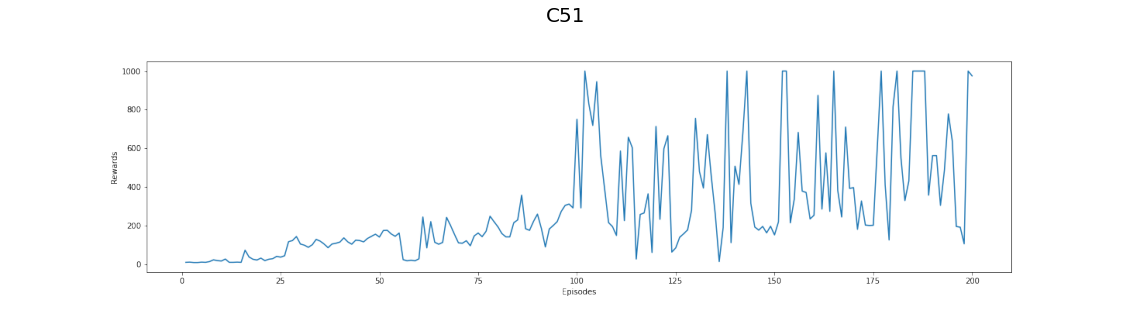

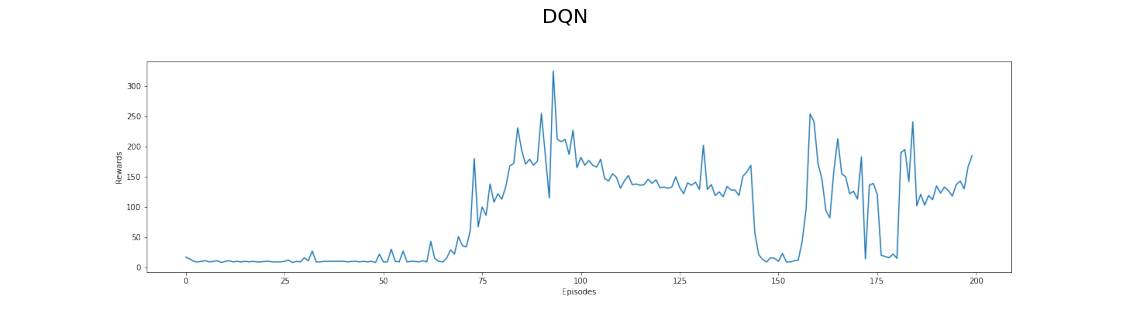

In [7]:
C51 = plt.imread("../C51/C51.png")
DQN = plt.imread("DQN.png")

fig, ax = plt.subplots(figsize=(20, 15))
ax.imshow(C51)
ax.axis('off')
ax.set_title("C51", fontsize=20)

fig, ax = plt.subplots(figsize=(20, 15))
ax.imshow(DQN)
ax.axis('off')
ax.set_title("DQN", fontsize=20)

plt.show()

Obviously, C51 outperforms DQN as it reaches higher rewards fast. 

Here, we have a rather noisy environment, so we are basically estimating the underlying environment through our observations. Generally speaking, approximating expectation of q-values for learning the actual values seems not to be a useful method compared with approximating the distribution of those values. This is because the existing noise (even non-stationary dynamics) can considerably negatively effect our choice of action when we represent our understaning of the environment just by a single value. This single value can be prone to unstability this way which in turn prevents us from selecting the best possible action. 